# Polarization tomography TSP: six-state scheme

In [126]:
import matplotlib.pyplot as plt
import numpy as np

from itertools import product

%matplotlib inline

## One-qubit case

### The tomography scheme

We assume a common tomography scheme using wave plates and a single detector:

![aaa](images/tomo_scheme_6s.png)

* **HWP**: a half-wave plate
* **QWP**: a quarter-wave plate
* **PBS**: a polarizing beam splitter
* **SPD**: a single-photon detector

### Wave plate angle specification

The wave plate angles are stored in the `ANGLES_6s` array. The angles for our six projections are as follows:

| projection | HWP angle | QWP angle |
|------------|-----------|-----------|
|      H     |     0.0   |     0     |
|      V     |    45.0   |     0     |
|      D     |    22.5   |     0     |
|      A     |   -22.5   |     0     |
|      R     |     0.0   |    45     |
|      L     |     0.0   |   -45     |

`ANGLES_6s` is defined in correspondence with this table:

In [4]:
ANGLES_6s = np.array([[0, 0],
                      [45, 0],
                      [22.5, 0],
                      [-22.5, 0],
                      [0, 45],
                      [0, -45]])

### The TSP adjacency matrix

For the one-qubit tomography case, we can directly proceed to the construction of the _TSP adjacency matrix_.

In [54]:
def adj_mat(angles):
    """Construct an adjacency matrix from the waveplate proj. angles.
    
    Args:
       * angles (numpy.array): A list of wave plate angles
                               for our tomographic projections.
    
    Returns:
       * adjacency_matrix (numpy.array): The appropriate
                                         TSP adjacency matrix.
    
    Note:
       * The 'distance' between any two measurement settings is taken as
         the maximum of the absolute-valued element-wise difference between
         the waveplate angles of the first and the second measurement.
    """
    # Compute the wave plate angle differences for the i -> j transition.
    # The result is an i,j-indexed matrix, element i,j is a vector with
    # two elements that indicate HWP angle change and QWP angle change.
    angular_diff = angles - angles[:, None]
    # Apply absolute value to this matrix, then take the highest element
    # of each of the size-2 i,j vectors (need to apply max along axis 2
    # of the numpy array).
    adjacency_matrix = np.max(np.abs(angular_diff), axis=2)
    return adjacency_matrix

We can now look at the adjacency matrix for one-qubit, six-state tomography:

In [55]:
adj_mat(ANGLES_6s)

array([[ 0. , 45. , 22.5, 22.5, 45. , 45. ],
       [45. ,  0. , 22.5, 67.5, 45. , 45. ],
       [22.5, 22.5,  0. , 45. , 45. , 45. ],
       [22.5, 67.5, 45. ,  0. , 45. , 45. ],
       [45. , 45. , 45. , 45. ,  0. , 90. ],
       [45. , 45. , 45. , 45. , 90. ,  0. ]])

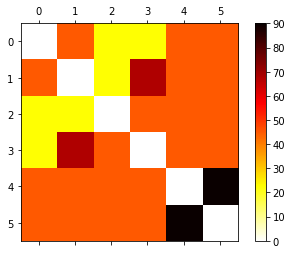

In [56]:
fig, ax = plt.subplots()
c = ax.matshow(adj_mat(ANGLES_6s), cmap="hot_r")
fig.colorbar(c)

### Formulating the TSPLIB compliant TSP

We use [Concorde](http://www.math.uwaterloo.ca/tsp/concorde.html), a [TSPLIB95](https://www.iwr.uni-heidelberg.de/groups/comopt/software/TSPLIB95/) compliant TSP solver.

TSPLIB95 Documentation, which specifies how the TSP file should look like is available [here](https://www.iwr.uni-heidelberg.de/groups/comopt/software/TSPLIB95/tsp95.pdf).

The `.tsp` file is a plain-text specification of the TSP. It starts with a header, where the problem name, type, dimension, are given, along with additional information.

The header always has the same basic form, and only the name, dimension, and optional comment fields change.

In [69]:
# The basic form of the header, with {} placeholders for
# name, dimension, and comment.
HEADER = """\
NAME : {n}
TYPE : TSP
COMMENT : {c}
DIMENSION : {d}
EDGE_WEIGHT_TYPE : EXPLICIT
EDGE_WEIGHT_FORMAT : FULL_MATRIX
EDGE_WEIGHT_SECTION
"""

The `{}` placeholder substitution is achieved using the `format()` function on the `HEADER` string. This is shown below:

In [71]:
name = "1q_6s.tsp"
dimension = 6
comment = "Wave plate tomography, 1 qubit, six-state"

print(HEADER.format(n=name, c=comment, d=dimension))

NAME : 1q_6s.tsp
TYPE : TSP
COMMENT : Wave plate tomography, 1 qubit, six-state
DIMENSION : 6
EDGE_WEIGHT_TYPE : EXPLICIT
EDGE_WEIGHT_FORMAT : FULL_MATRIX
EDGE_WEIGHT_SECTION



The adjacency matrix follows the header. The file ends with the string `"EOF"`.

All that remains is to save the .tsp file, with the adjacency matrix of the problem. It is useful to define a function for this:

In [73]:
def save_tsp(filename, adjacency_matrix, comment=""):
    """Save a given adjacency matrix in TSPLIB95 form.
    
    Args:
       * filename (str): The name of the .tsp file.
       * adjacency_matrix (numpy.array): The adjacency matrix.
    
    Kwargs:
       * comment (str): The comment that appears in the header
                        of the .tsp file (optional).
                        Defaults to an empty string.
    
    Notes:
       We ran into trouble when solving the TSP with float matrices.
       As we will encounter matrix elements like 67.5, we multiply
       the adjacency matrix by 2 for the solver.
       
       As each adjacency matrix element has been multiplied by the
       same factor, this will not affect the solution. When we evaluate
       the speedup, we use adjacency matrices which **were not** multiplied
       to provide the correct results.
    """
    dimension = len(adjacency_matrix)  # determine the dim of TSP
    adjacency_matrix *= 2  # multiply by 2 to avoid floats
    np.savetxt(filename, adjacency_matrix,
               header=HEADER.format(n=filename, d=dimension, c=comment),
               footer="EOF", comments="", fmt="%d")  # converted to int

Save the one-qubit, six-state tomography TSP:

In [75]:
filename = "1q_6s.tsp"
comment = "Wave plate tomography, 1 qubit, six-state"

save_tsp(filename, adj_mat(ANGLES_6s), comment)

### Solving the TSP

Call Concorde. For this to work, make sure that you can run concorde from the terminal (its location must be in the `PATH` variable). Alternatively, placing the `concorde` executable in this directory should work as well.

The `-x` parameter allows concorde to delete temporary files after solving the TSP.

_Also note that this way of calling external commands is specific to Jupyter notebooks. In ordinary Python, functions like `call()` from the `subprocess` module would have to be used._

In [80]:
!concorde -x 1q_6s.tsp

concorde -x 1q_6s.tsp
Host: nadezdan  Current process id: 6360
Using random seed 1542024784
Problem Name: 1q_6s.tsp
Problem Type: TSP
Wave plate tomography, 1 qubit, six-state
Number of Nodes: 6
Explicit Lengths (CC_MATRIXNORM)
Optimal Solution: 450.00
Total Running Time: 0.00 (seconds)


Another file, `1q_6s.sol` should appear in the working directory. It contains, in plain text, a sequence of node indexes that form the solution of the TSP. The numbers 0 through 5 can be identified with the six projection measurements `H`, `V`, `D`, `A`, `R`, `L`, in this order.

Opening the file, we can see that in our case, the sequence (or _path_)is:

1. 0 (H)
2. 5 (L)
3. 3 (A)
4. 4 (R)
5. 1 (V)
6. 2 (D)

We define a function that extracts this sequence from the `.sol` file. The function is more complicated than seems necessary at this point. However, it will work with the `.sol` files of higher-dimension TSPs, where the solution is split onto multiple lines.

In [94]:
def get_projs(filename):
    """Retrieves the order of projections from the .sol file.
    
    Args:
       * filename (str): The name of the .sol file.
    
    Returns:
       * path (list): The TSP-optimal sequence of projection indices.
    """
    with open(filename, "r") as f:  # open the file
        # collect the lines of the file
        # skip the first line, strip endline characters
        lines = map(lambda x: x.rstrip(" \n"), f.readlines()[1:])
    # join the lines into space-separated string of indices
    joined_lines = " ".join(list(lines))
    # convert to a list of integers
    path = list(map(int, joined_lines.split(" ")))
    return path

We can test this function on our solution to the one-qubit, six-state tomography TSP:

In [96]:
tsp_path = get_projs("1q_6s.sol")
print(tsp_path)

[0, 5, 3, 4, 1, 2]


### Evaluating speedup

We will now use the TSP-optimal path to determine the total (angular) duration of optimized one-qubit, six-state tomography. To do this, we convert the path into a list of _edges_, or transitions between the individual measurements. Then, we will be able to sum the adjacency matrix elements that correspond to these edges to obtain the total duration.

We are interested in the _cycle length_, meaning that we consider the transition from the last to the first measurement (so that our tomography ends where it started off).

In [102]:
def cycle_length(adj_matrix, path):
    """Compute the length of a cycle for a given adj. matrix and path.
    
    Args:
       * adj_matrix (numpy.array): The appropriate adjacency matrix.
       * path (list): A list of projection indices.
    
    Returns:
       * cycle_length (float): The cycle length.
    """
    # convert the path to a list of edges, or transitions
    # create pairs of nth and (n+1)th path indices
    edges = [[path[n], path[n+1]] for n in range(len(path) - 1)]
    # add the final transition that completes the cycle
    edges += [[path[-1], path[0]]]
    cycle_length = sum([adj_matrix[edge[0]][edge[1]] for edge in edges])
    return cycle_length

Let's see the TSP-optimal cycle length:

In [107]:
tsp_cycle = cycle_length(adj_mat(ANGLES_6s), tsp_path)
print(tsp_cycle)

225.0


The conventional ordering of tomography goes through the polarization projection in the order `H`, `V`, `D`, `A`, `R`, `L`. When we defined `ANGLES_6s`, we gave the wave the wave plate angles for the projections in this order. We can then obtain the conventional cycle length by giving `[0, 1, 2, 3, 4, 5]`, or `range(6)` as the `path` argument to the function `cycle_length()`:

In [108]:
conv_cycle = cycle_length(adj_mat(ANGLES_6s), range(6))
print(conv_cycle)

292.5


We define the TSP speedup as the ratio between the conventional and the TSP-optimal cycle length:

In [110]:
speedup = conv_cycle / tsp_cycle
print(speedup)

1.3


The _reduction_ of total duration is also of importance:

In [145]:
reduction = conv_cycle - tsp_cycle
print(reduction)

67.5


## Multiple qubits

The procedure is almost identical for multiple qubits. The only exception is that `ANGLES_6s` cannot be used anymore. For an $n$-qubit system, $6^n$ projections need to be measured. Furthermore, $2\times n$ wave plates are required. We need to construct a wave plate angle list, similar to `ANGLES_6s`, for all the projections. This can be understood as a 'Cartesian power' of `ANGLES_6s`

We will use the `product()` function from the `itertools` module to generate said Cartesian power.

In [132]:
def nqubit_angles(one_qubit_angles, n):
    cartesian = product(one_qubit_angles, repeat=n)
    # We have just generated a list of n-tuples of 1x2 arrays.
    # To convert it to a list of 1x2n arrays, stack the n 1x2 arrays
    # horizontally for each n-tuple of the list.
    array_list = map(np.hstack, cartesian)
    # Finally, convert the list of 1x2n arrays to one 2D array
    angles = np.vstack(array_list)
    return angles

To check, see how the 2-qubit wave plate angles array turns out:

In [134]:
ANGLES_6s_2qubit = nqubit_angles(ANGLES_6s, 2)
print(ANGLES_6s_2qubit)

[[  0.    0.    0.    0. ]
 [  0.    0.   45.    0. ]
 [  0.    0.   22.5   0. ]
 [  0.    0.  -22.5   0. ]
 [  0.    0.    0.   45. ]
 [  0.    0.    0.  -45. ]
 [ 45.    0.    0.    0. ]
 [ 45.    0.   45.    0. ]
 [ 45.    0.   22.5   0. ]
 [ 45.    0.  -22.5   0. ]
 [ 45.    0.    0.   45. ]
 [ 45.    0.    0.  -45. ]
 [ 22.5   0.    0.    0. ]
 [ 22.5   0.   45.    0. ]
 [ 22.5   0.   22.5   0. ]
 [ 22.5   0.  -22.5   0. ]
 [ 22.5   0.    0.   45. ]
 [ 22.5   0.    0.  -45. ]
 [-22.5   0.    0.    0. ]
 [-22.5   0.   45.    0. ]
 [-22.5   0.   22.5   0. ]
 [-22.5   0.  -22.5   0. ]
 [-22.5   0.    0.   45. ]
 [-22.5   0.    0.  -45. ]
 [  0.   45.    0.    0. ]
 [  0.   45.   45.    0. ]
 [  0.   45.   22.5   0. ]
 [  0.   45.  -22.5   0. ]
 [  0.   45.    0.   45. ]
 [  0.   45.    0.  -45. ]
 [  0.  -45.    0.    0. ]
 [  0.  -45.   45.    0. ]
 [  0.  -45.   22.5   0. ]
 [  0.  -45.  -22.5   0. ]
 [  0.  -45.    0.   45. ]
 [  0.  -45.    0.  -45. ]]


This is a list of $6^2 = 36$ polarization projections `HH`, `HV`, ..., `HR`, `HL`, `VH`, `VV`, ..., `LR`, `LL`. The four angles now correspond to $\mathrm{HWP}_1$, $\mathrm{QWP}_1$, $\mathrm{HWP}_2$, $\mathrm{QWP}_2$, respectively, with the index corresponding to qubit 1 or qubit 2 of the two-qubit system.

As the rest is identical to the one-qubit case, we will now proceed faster and generate, solve, and evaluate the tomograpy TSPs for up to 4-qubit system.

In [138]:
for nqubits in range(1, 5):
    nqu_angles = nqubit_angles(ANGLES_6s, nqubits)
    adjacency_matrix = adj_mat(nqu_angles)
    
    tsp_filename = "{}q_6s.tsp".format(nqubits)
    tsp_comment = "Wave plate tomography, {} qubits, six-state".format(nqubits)

    save_tsp(tsp_filename, adjacency_matrix, tsp_comment)

With all the TSP files generated, call Concorde for each (except one-qubit, it has been solved already). In the summary Concorde gives upon completion, notice how execution time increases.

In [140]:
!concorde -x 2q_6s.tsp

concorde -x 2q_6s.tsp
Host: nadezdan  Current process id: 7801
Using random seed 1542028785
Problem Name: 2q_6s.tsp
Problem Type: TSP
Wave plate tomography, 2 qubits, six-state
Number of Nodes: 36
Explicit Lengths (CC_MATRIXNORM)
Set initial upperbound to 2025 (from tour)
  LP Value  1: 2025.000000  (0.01 seconds)
New lower bound: 2025.000000
Final lower bound 2025.000000, upper bound 2025.000000
Exact lower bound: 2025.000000
DIFF: 0.000000
Final LP has 45 rows, 77 columns, 221 nonzeros
Optimal Solution: 2025.00
Number of bbnodes: 1
Total Running Time: 0.09 (seconds)


In [141]:
!concorde -x 3q_6s.tsp

concorde -x 3q_6s.tsp
Host: nadezdan  Current process id: 7806
Using random seed 1542028799
Problem Name: 3q_6s.tsp
Problem Type: TSP
Wave plate tomography, 3 qubits, six-state
Number of Nodes: 216
Explicit Lengths (CC_MATRIXNORM)
Set initial upperbound to 10935 (from tour)
  LP Value  1: 10800.000000  (0.29 seconds)
  LP Value  2: 10890.000000  (0.46 seconds)
  LP Value  3: 10935.000000  (0.93 seconds)
  LP Value  4: 10935.000000  (1.55 seconds)
New lower bound: 10935.000000
Final lower bound 10935.000000, upper bound 10935.000000
Exact lower bound: 10935.000000
DIFF: 0.000000
Final LP has 479 rows, 569 columns, 7429 nonzeros
Optimal Solution: 10935.00
Number of bbnodes: 1
Total Running Time: 5.05 (seconds)


In [142]:
!concorde -x 4q_6s.tsp

concorde -x 4q_6s.tsp
Host: nadezdan  Current process id: 7814
Using random seed 1542028810
Problem Name: 4q_6s.tsp
Problem Type: TSP
Wave plate tomography, 4 qubits, six-state
Number of Nodes: 1296
Explicit Lengths (CC_MATRIXNORM)
Set initial upperbound to 61965 (from tour)
  LP Value  1: 61065.000000  (0.67 seconds)
  LP Value  2: 61875.000000  (2.08 seconds)
  LP Value  3: 61920.000000  (6.20 seconds)
  LP Value  4: 61920.000000  (51.25 seconds)
New lower bound: 61919.999999
  LP Value  1: 61965.000000  (81.99 seconds)
New lower bound: 61965.000000
Final lower bound 61965.000000, upper bound 61965.000000
Exact lower bound: 61965.000000
DIFF: 0.000000
Final LP has 2309 rows, 3162 columns, 76413 nonzeros
Optimal Solution: 61965.00
Number of bbnodes: 1
Total Running Time: 121.09 (seconds)


Now we can evaluate how the TSP speedup and total duration reduction scales with the number of qubits in the system:

In [149]:
speedups, reductions = [], []
for nqubits in range(1, 5):
    print("{} qubits:".format(nqubits))
    nqu_angles = nqubit_angles(ANGLES_6s, nqubits)
    adjacency_matrix = adj_mat(nqu_angles)
    sol_filename = "{}q_6s.sol".format(nqubits)
    solution = get_projs(sol_filename)
    
    optimal_cycle = cycle_length(adjacency_matrix, solution)
    conv_cycle = cycle_length(adjacency_matrix, range(len(adjacency_matrix)))
    speedup = conv_cycle / optimal_cycle
    reduction = conv_cycle - optimal_cycle
    print(optimal_cycle)
    print(conv_cycle)
    print(speedup)
    print(reduction)

1 qubits:
225.0
292.5
1.3
67.5
2 qubits:
1012.5
1800.0
1.7777777777777777
787.5
3 qubits:
5467.5
10845.0
1.9835390946502058
5377.5
4 qubits:
30982.5
65115.0
2.101670297748729
34132.5
